In [3]:
from osgeo import gdal
from osgeo.gdalconst import *
import os, os.path
import numpy as np
import rasterio   
import matplotlib.pyplot as plt

In [4]:
def annulus_weight(altitude, aziinterval):
    '''assign different weight to different annulus'''
    n = 90.
    steprad = (360./aziinterval) * (np.pi/180.)
    annulus = 91.-altitude
    w = (1./(2.*np.pi)) * np.sin(np.pi / (2.*n)) * np.sin((np.pi * (2. * annulus - 1.)) / (2. * n))
    weight = steprad * w
    
    return weight
    

def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())



# def shadowingfunctionglobalradiation(a, azimuth, altitude, scale, dlg, forsvf):
def shadowingfunctionglobalradiation(a, azimuth, altitude, scale, forsvf):
    import numpy as np
    
    #%This m.file calculates shadows on a DEM
    #% conversion
    degrees = np.pi/180.
    if azimuth == 0.0:
        azimuth = 0.000000000001
    azimuth = np.dot(azimuth, degrees)
    altitude = np.dot(altitude, degrees)
    #% measure the size of the image
    sizex = a.shape[0]
    sizey = a.shape[1]
    if forsvf == 0:
        barstep = np.max([sizex, sizey])
#         dlg.progressBar.setRange(0, barstep)
    #% initialise parameters
    f = a
    dx = 0.
    dy = 0.
    dz = 0.
    temp = np.zeros((sizex, sizey))
    index = 1.
    #% other loop parameters
    amaxvalue = a.max()
    pibyfour = np.pi/4.
    threetimespibyfour = 3.*pibyfour
    fivetimespibyfour = 5.*pibyfour
    seventimespibyfour = 7.*pibyfour
    sinazimuth = np.sin(azimuth)
    cosazimuth = np.cos(azimuth)
    tanazimuth = np.tan(azimuth)
    signsinazimuth = np.sign(sinazimuth)
    signcosazimuth = np.sign(cosazimuth)
    dssin = np.abs((1./sinazimuth))
    dscos = np.abs((1./cosazimuth))
    tanaltitudebyscale = np.tan(altitude) / scale
    
    #% main loop
    while (amaxvalue >= dz and np.abs(dx) < sizex and np.abs(dy) < sizey):
#         if forsvf == 0:
#             dlg.progressBar.setValue(index)
    #while np.logical_and(np.logical_and(amaxvalue >= dz, np.abs(dx) <= sizex), np.abs(dy) <= sizey):(np.logical_and(amaxvalue >= dz, np.abs(dx) <= sizex), np.abs(dy) <= sizey):
        #if np.logical_or(np.logical_and(pibyfour <= azimuth, azimuth < threetimespibyfour), np.logical_and(fivetimespibyfour <= azimuth, azimuth < seventimespibyfour)):
        if (pibyfour <= azimuth and azimuth < threetimespibyfour or fivetimespibyfour <= azimuth and azimuth < seventimespibyfour):
            dy = signsinazimuth * index
            dx = -1. * signcosazimuth * np.abs(np.round(index / tanazimuth))
            ds = dssin
        else:
            dy = signsinazimuth * np.abs(np.round(index * tanazimuth))
            dx = -1. * signcosazimuth * index
            ds = dscos

        #% note: dx and dy represent absolute values while ds is an incremental value
        dz = ds *index * tanaltitudebyscale
        temp[0:sizex, 0:sizey] = 0.
        absdx = np.abs(dx)
        absdy = np.abs(dy)
        xc1 = (dx+absdx)/2.+1.
        xc2 = sizex+(dx-absdx)/2.
        yc1 = (dy+absdy)/2.+1.
        yc2 = sizey+(dy-absdy)/2.
        xp1 = -((dx-absdx)/2.)+1.
        xp2 = sizex-(dx+absdx)/2.
        yp1 = -((dy-absdy)/2.)+1.
        yp2 = sizey-(dy+absdy)/2.
        temp[int(xp1)-1:int(xp2), int(yp1)-1:int(yp2)] = a[int(xc1)-1:int(xc2), int(yc1)-1:int(yc2)]-dz
        # f = np.maximum(f, temp)  # bad performance in python3. Replaced with fmax
        f = np.fmax(f, temp)
        index += 1.
    
    f = f-a
    f = np.logical_not(f)
    sh = np.double(f)
    
    return sh
    

('float32',)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.4028234663852886e+38, 'width': 647, 'height': 296, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(6.486580116153585e-06, 0.0, 4.888108487358384,
       0.0, -6.486580116153585e-06, 52.364128133323035)}


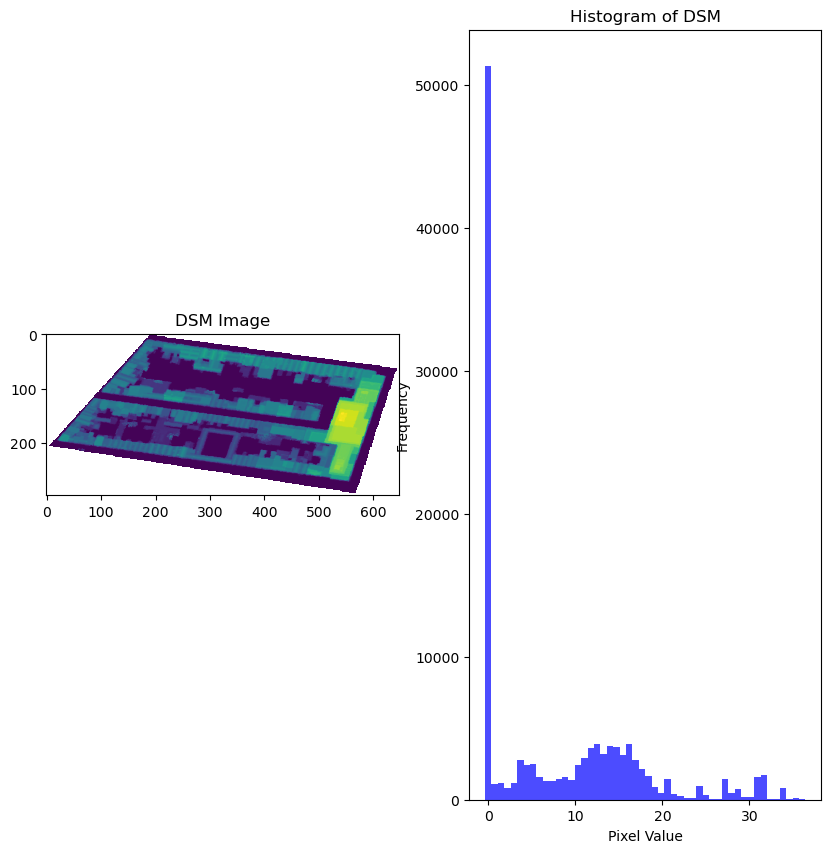

In [29]:
root = '../data/clean_data'
# demfile = os.path.join(root, 'clipedDEM.tif') # LB: 240417
dsmfile = os.path.join(root, 'mask_clip_repr.tif')


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1, masked=True)
    print(dsmlayer.dtypes)
    print(dsmlayer.meta)
    # raster_transform = dsmlayer.transform
    plt.figure(figsize=(10, 10))
    # Display the raster image
    plt.subplot(1, 2, 1)
    plt.imshow(dsmimg, cmap='viridis')
    plt.title('DSM Image')
    
    # Display the histogram of raster values
    plt.subplot(1, 2, 2)
    plt.hist(dsmimg.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of DSM')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.show()

In [12]:
root = '../data/clean_data'
# demfile = os.path.join(root, 'clipedDEM.tif') # LB: 240417
dsmfile = os.path.join(root, 'masked_raster.tif')


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1, masked=True)


gdal_dsm = gdal.Open(dsmfile)
dsm = gdal_dsm.ReadAsArray().astype(float)#dsm

# ------
# LB:240417, not needed after all.
# Get nodata value # LB: 240417
# nodata_value = gdal_dsm.GetRasterBand(1).GetNoDataValue()

# Mask nodata values # LB: 240417
# dsm = np.ma.masked_equal(dsm, nodata_value)
# print(dsm)

# Replace nodata values with 0 (instead of masking above) # LB: 240417
# dsm[dsm == nodata_value] = 0
# print(dsm)

# -----



geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]

# gdal_dem = gdal.Open(demfile) #dem # LB: 240417
# dem = gdal_dem.ReadAsArray().astype(np.float) # LB: 240417


rows = dsm.shape[0]
cols = dsm.shape[1]
svf = np.zeros([rows, cols])
svfE = svf
svfS = svf
svfW = svf
svfN = svf
svfveg = np.zeros((rows, cols))
svfEveg = np.zeros((rows, cols))
svfSveg = np.zeros((rows, cols))
svfWveg = np.zeros((rows, cols))
svfNveg = np.zeros((rows, cols))
svfaveg = np.zeros((rows, cols))
svfEaveg = np.zeros((rows, cols))
svfSaveg = np.zeros((rows, cols))
svfWaveg = np.zeros((rows, cols))
svfNaveg = np.zeros((rows, cols))

# % amaxvalue
# vegmax = self.vegdem.max()
amaxvalue = dsmimg.max()
# amaxvalue = np.maximum(amaxvalue, vegmax)

shmat = np.zeros((rows, cols, 145))
vegshmat = np.zeros((rows, cols, 145))

index = int(0)

# LB: 240417; How to adapt this? Must check UMEP code.
iangle = np.array([6, 18, 30, 42, 54, 66, 78, 90])
skyvaultaziint = np.array([12, 12, 15, 15, 20, 30, 60, 360])
aziinterval = np.array([30, 30, 24, 24, 18, 12, 6, 1])
azistart = np.array([0, 4, 2, 5, 8, 0, 10, 0])
annulino = np.array([0, 12, 24, 36, 48, 60, 72, 84, 90])
iazimuth = np.hstack(np.zeros((1, 145)))
#ialtitude = np.zeros((1, 145))
skyvaultaltint = np.array([6, 18, 30, 42, 54, 66, 78, 90])

for j in range(0, 8):
    for k in range(0, int(360 / skyvaultaziint[j])):
        iazimuth[index] = k * skyvaultaziint[j] + azistart[j]
        if iazimuth[index] > 360.:
            iazimuth[index] = iazimuth[index] - 360.
        index = index + 1


aziintervalaniso = np.ceil(aziinterval / 2.0)
index = int(0)

#for i in np.arange(0, iangle.shape[0]-1):
for i in range(0, skyvaultaltint.shape[0]):
    for j in np.arange(0, (aziinterval[int(i)])):
        altitude = iangle[int(i)]
        azimuth = iazimuth[int(index)-1]           
        
#         sh = shadow.shadowingfunctionglobalradiation(dsmimg, azimuth, altitude, self.scale, self.dlg, 1)
        sh = shadowingfunctionglobalradiation(dsmimg, azimuth, altitude, scale, 1)
        shmat[:, :, index] = sh
        
        
        # Calculate svfs
        for k in np.arange(annulino[int(i)]+1, (annulino[int(i+1.)])+1):
            weight = annulus_weight(k, aziinterval[i])*sh
            svf = svf + weight
            weight = annulus_weight(k, aziintervalaniso[i]) * sh
            if (azimuth >= 0) and (azimuth < 180):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfE = svfE + weight
            if (azimuth >= 90) and (azimuth < 270):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfS = svfS + weight
            if (azimuth >= 180) and (azimuth < 360):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfW = svfW + weight
            if (azimuth >= 270) or (azimuth < 90):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfN = svfN + weight
        
        index += 1    


svfS = svfS + 3.0459e-004
svfW = svfW + 3.0459e-004
# % Last azimuth is 90. Hence, manual add of last annuli for svfS and SVFW
# %Forcing svf not be greater than 1 (some MATLAB crazyness)
svf[(svf > 1.)] = 1.
svfE[(svfE > 1.)] = 1.
svfS[(svfS > 1.)] = 1.
svfW[(svfW > 1.)] = 1.
svfN[(svfN > 1.)] = 1.


svfresult = {'svf': svf, 'svfE': svfE, 'svfS': svfS, 'svfW': svfW, 'svfN': svfN,
                'svfveg': svfveg, 'svfEveg': svfEveg, 'svfSveg': svfSveg, 'svfWveg': svfWveg,
                'svfNveg': svfNveg, 'svfaveg': svfaveg, 'svfEaveg': svfEaveg, 'svfSaveg': svfSaveg,
                'svfWaveg': svfWaveg, 'svfNaveg': svfNaveg, 'shmat': shmat,'vegshmat': vegshmat}


svffile = 'svf.tif'
svfWfile = 'svfW.tif'
svfNfile = 'svfN.tif'
saverasternd(gdal_dsm, svffile, svf)
saverasternd(gdal_dsm, svfWfile, svfW)
saverasternd(gdal_dsm, svfNfile, svfN)

: 